# Set Up Repos from GitHub

In [1]:
import sys
import os
import shutil
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/tensorflow/probability.git

sys.path.append('/content/probability')

fatal: destination path 'probability' already exists and is not an empty directory.


# Other package imports

In [3]:
import time

from functools import reduce

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%tensorflow_version 2.x
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import operator 

tfb = tfp.bijectors
tfd = tfp.distributions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions for Scoring

Data generated as $X_1, \ldots, X_n \sim \text{Normal}(0, 1)$

In [0]:
def log_score_norm(x, loc, scale):
  return stats.norm.logpdf(x=x, loc=loc, scale=scale)


def log_score_from_sample(preds, x, lower_bin, upper_bin, bin_width = 0.1):
  bins = np.arange(lower_bin, upper_bin, bin_width)
  pred_hist = np.histogram(preds, bins = bins, density=True)
  obs_hist = np.histogram(x, bins = bins, density=True)
  return np.log(pred_hist[0][np.nonzero(obs_hist[0])[0]])


def interval_score(x, l, u, alpha):
  score = (u - l) + \
    np.where(x < l, 2./alpha * (l - x), 0.) + \
    np.where(x > u, 2./alpha * (x - u), 0.)
  return score


def interval_score_norm(x, loc, scale, alpha):
  l, u = stats.norm.interval(alpha=1. - alpha, loc=loc, scale=scale)
  return interval_score(x, l, u, alpha)


# out of date
#def interval_score_from_sample(preds, x, alpha = 0.1):
#  (l, u) = np.quantile(preds, (alpha/2., 1. - alpha/2.))
#  score = interval_score(x=x, l=l, u=u, alpha=alpha)
#  return score


def interval_ae_score(x, m, l, u, alpha):
  score = np.abs(m - x) + \
    interval_score(x, l, u, alpha)
  return score


def interval_ae_score_norm(x, loc, scale, alpha):
  l, u = stats.norm.interval(alpha=1. - alpha, loc=loc, scale=scale)
  return interval_ae_score(x, loc, l, u, alpha)

# out of date
#def interval_ae_score_from_sample(preds, x, alpha = 0.1):
#  score = np.abs(np.median(preds) - x) + \
#    interval_score_from_sample(preds, x, alpha = alpha)
#  return score

# Study Number 1: Fixed Predictive Distributions

### Data generating process and predictive models

We sample $X \sim \text{Normal}(0,1)$; this is our target for prediction.

We evaluate predictions from four fixed predictive distributions:

 * $\hat{X}_1 \sim \text{Normal}(0, 1)$: the data generating process
 * $\hat{X}_2 \sim \text{Normal}(0, 0.8)$: miscalibrated, too narrow
 * $\hat{X}_3 \sim \text{Normal}(0, 1.2)$: miscalibrated, too wide
 * $\hat{X}_4 \sim \text{Normal}(0.2, 1.2)$: biased and miscalibrated, too wide



In [0]:
# predictive model names and parameters
model_names = ['DGP', 'narrow', 'wide', 'bias_wide']
locs = [0., 0., 0., 0.2]
scales = [1., 0.8, 1.2, 1.2]

### Scoring rules

Our goal is to study the ability of the following scoring rules to distinguish between these models and identify $\hat{X}_1$ as the best model.

In [0]:
score_funs = [
  log_score_norm,
  lambda x, loc, scale: interval_score_norm(x, loc, scale, alpha=0.5),
  lambda x, loc, scale: interval_score_norm(x, loc, scale, alpha=0.05),
  lambda x, loc, scale: interval_ae_score_norm(x, loc, scale, alpha=0.5),
  lambda x, loc, scale: interval_ae_score_norm(x, loc, scale, alpha=0.05)]

score_names = [
  'log_score', 'interval_0.5', 'interval_0.05', 'interval_ae_0.5',
  'interval_ae_0.05'
]

### Finding scores

Calculate the scores each model would receive based on 1000 samples from the data generating process (a Normal(0, 1) distribution).

In [0]:
def compute_all_model_scores(x):
  scores = [pd.DataFrame({'model': model_names[i],
    'score_name': score_name,
    'score': score_fun(x, loc, scale)}, index=[0]) \
      for i, (loc, scale) in enumerate(zip(locs, scales)) \
        for score_name, score_fun in zip(score_names, score_funs)
  ]

  return pd.concat(scores, axis = 0)

x = np.random.standard_normal(1000)
all_scores = pd.concat(
  [compute_all_model_scores(x_i).assign(sample=i) for i,x_i in enumerate(x)],
  axis = 0
)

In [8]:
all_scores

,model,score_name,score,sample
0,DGP,log_score,-0.924462,0
0,DGP,interval_0.5,1.348980,0
0,DGP,interval_0.05,3.919928,0
0,DGP,interval_ae_0.5,1.454087,0
0,DGP,interval_ae_0.05,4.025035,0
...,...,...,...,...
0,bias_wide,log_score,-1.361218,999
0,bias_wide,interval_0.5,1.842277,999
0,bias_wide,interval_0.05,4.703914,999
0,bias_wide,interval_ae_0.5,2.707540,999


### Summarizing scores
Mean scores

In [9]:
all_scores.drop('sample', axis=1) \
  .groupby(['model', 'score_name']) \
  .mean() \
  .reset_index(level='score_name') \
  .pivot(columns='score_name')

score               ...                          
score_name interval_0.05 interval_0.5  ... interval_ae_0.5 log_score
model                                  ...                          
DGP             4.730529     2.612498  ...        3.436905 -1.445909
bias_wide       5.005555     2.665779  ...        3.500871 -1.479390
narrow          5.429114     2.646363  ...        3.470771 -1.519186
wide            4.909461     2.628293  ...        3.452700 -1.467211

[4 rows x 5 columns]

Plots

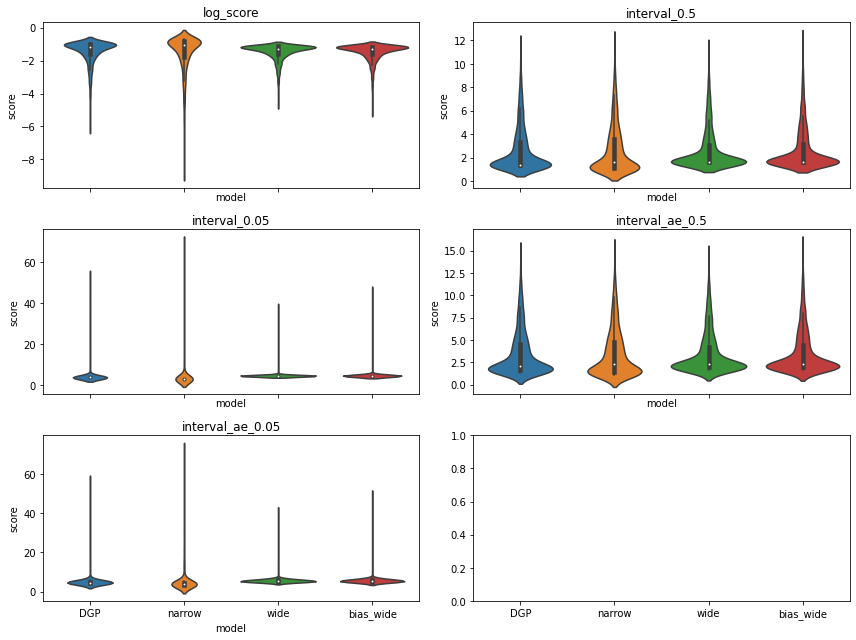

In [11]:
f, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey=False)

for i, ax in enumerate(axes.flat):
  if i < len(score_names):
    sns.violinplot(x='model', y='score',
        data=all_scores[all_scores.score_name==score_names[i]],
        ax=ax) \
      .set_title(score_names[i])

f.tight_layout()

### Small sample sizes

How reliably can we distinguish the models based on mean scores across varying numbers of observations?

The goal is to understand the distribution of the score.

The weirdness in some of the plots below is because for the interval scores with $\alpha = 0.05$, there are not that many unique values of the score; the IQR (used to select bandwidth) is actually 0.  I'm leaving this in because it's interesting to note and I'm a little worried it may point to a bug in my code?  A version of the plot with manually calculated bandwidth for kde is below.

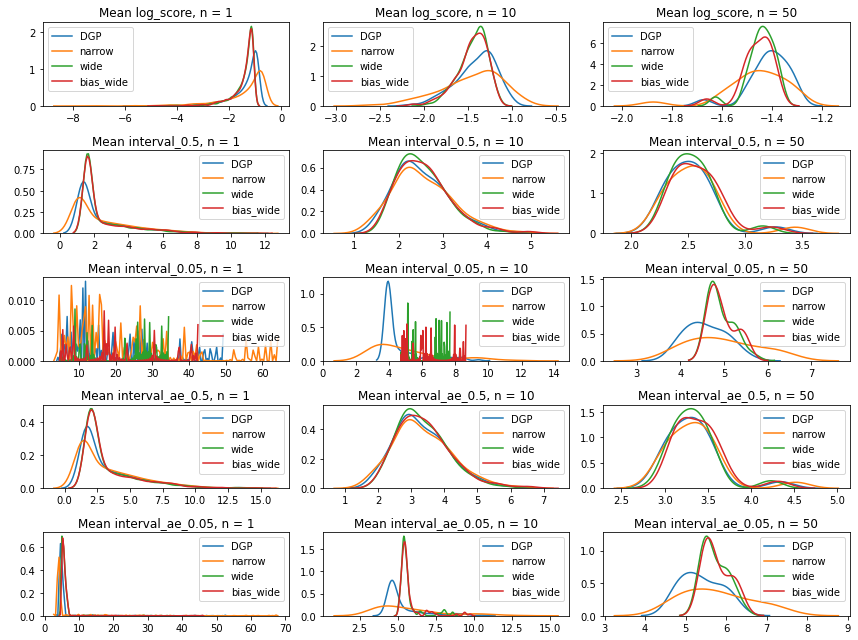

In [20]:
f, axes = plt.subplots(5, 3, figsize=(12, 9), sharex=False, sharey=False)

sample_sizes = [1, 10, 50]


for j, sample_size in enumerate(sample_sizes):
  score_summaries = all_scores \
    .assign(sample_group = all_scores['sample'] // sample_size) \
    .groupby(['model', 'score_name', 'sample_group']) \
    .mean() \
    .reset_index(level = ['model', 'score_name'])
  
  for i, score_name in enumerate(score_names):
    score_summaries_one_score = score_summaries \
      .loc[score_summaries['score_name'] == score_name, :]
    
    for model_name in model_names:
      model_scores = score_summaries_one_score \
        .loc[score_summaries_one_score['model'] == model_name, 'score']
      
      sns.kdeplot(
        model_scores,
        label=model_name,
        ax=axes[i, j]) \
      .set_title('Mean ' + score_name + ', n = ' + str(sample_size))

f.tight_layout()

Version of the plot with manually selected bandwidth.

In [0]:
f, axes = plt.subplots(5, 3, figsize=(12, 9), sharex=False, sharey=False)

sample_sizes = [1, 10, 50]


for j, sample_size in enumerate(sample_sizes):
  score_summaries = all_scores \
    .assign(sample_group = all_scores['sample'] // sample_size) \
    .groupby(['model', 'score_name', 'sample_group']) \
    .mean() \
    .reset_index(level = ['model', 'score_name'])
  
  for i, score_name in enumerate(score_names):
    score_summaries_one_score = score_summaries \
      .loc[score_summaries['score_name'] == score_name, :]
    
    for model_name in model_names:
      model_scores = score_summaries_one_score \
        .loc[score_summaries_one_score['model'] == model_name, 'score']
      
      # manual calculation of bandwidth because of 0.05 weirdness
      scale_val= np.max(
          [np.diff(model_scores.quantile(q = [0.25, 0.75]).to_numpy())[0],
          model_scores.std()]
      )
      h = 0.8 * scale_val * sample_size**(-0.2)

      sns.kdeplot(
        model_scores,
        label=model_name,
        bw = h,
        ax=axes[i, j]) \
      .set_title('Mean ' + score_name + ', n = ' + str(sample_size))

f.tight_layout()

# Study Number 2: Models Estimated from Simulated Data

I started on this and abandoned it because it was unnecessarily complicated.

## Model Specification

# Model definitions

### Model 1

\begin{align*}
X_1, \ldots, X_n &\sim \text{Normal}(\mu, \sigma^2) \\
\mu &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Gamma}\left((1/0.5)^2, 1/0.5^2\right)
\end{align*}

The prior distribution for $\sigma^2$ has mean 1 and standard deviation 0.5.

### Model 2

\begin{align*}
X_1, \ldots, X_n &\sim \text{Normal}(\mu, \sigma^2) \\
\mu &\sim \text{Normal}(0.5, 1) \\
\sigma &\sim \text{Gamma}((1.5/0.1)^2, 1.5/0.1^2)
\end{align*}

The prior distribution for $\sigma^2$ has mean 1.5 and standard deviation 0.1.

In [0]:
def build_model(n, prior_params):
  mu_prior_mean, mu_prior_stddev, sigma_prior_mean, sigma_prior_stddev = prior_params
  sigma_concentration = (sigma_prior_mean / sigma_prior_stddev)**2
  sigma_rate = sigma_prior_mean / sigma_prior_stddev**2

  model = tfd.JointDistributionNamed({
      'mu': tfd.Normal(loc=mu_prior_mean, scale=mu_prior_stddev, name='mu', validate_args=True, allow_nan_stats=False),
      'sigma': tfd.Gamma(concentration=sigma_concentration, rate=sigma_rate,
        name='sigma', validate_args=True, allow_nan_stats=False),
      'x': lambda mu, sigma: tfd.Independent(
          tfd.Normal(
              loc=tf.ones((n,)) * mu,
              scale=tf.ones((n,)) * sigma, validate_args=True, allow_nan_stats=False
          ),
          name='x',
          reinterpreted_batch_ndims=1, validate_args=True
        )
  })

  return model


# prior parameters for each model
# wait to create models later when we know n
model1_prior_params = (0., 10., 1.5, 0.5)
model2_prior_params = (2, 1., 4, 1.)
model3_prior_params = (1, 1., 2, 1.)

In [270]:
# sanity check model by sampling and evaluating log probability
test_model = build_model(n=10, prior_params = model1_prior_params)

test_sample = test_model.sample()
lp = test_model.log_prob(test_sample)

print("sampled {}".format(test_sample))
print("log_prob of sample: {}".format(lp))

sampled {'sigma': <tf.Tensor: shape=(), dtype=float32, numpy=0.95076364>, 'mu': <tf.Tensor: shape=(), dtype=float32, numpy=5.326769>, 'x': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([6.7643175, 6.14727  , 5.4004893, 4.506711 , 6.006737 , 5.5491457,
       5.377436 , 5.218852 , 3.0700855, 4.5321655], dtype=float32)>}
log_prob of sample: -17.982635498046875


In [0]:
class ModelFitter():
  '''
  The intent is to save on model compilation time when refitting the same model
  to new data.
  '''
  def __init__(self, model, x):
    '''
    Arguments:
      - model: tfp model
    '''
    self.model = model
    self.x = x

    # define sampler with constraint that sampled values of sigma are positive
    identity = tfb.Identity()
#    constrain_positive = tfb.Shift(np.finfo(np.float32).tiny)(tfb.Softplus())
    constrain_positive = tfb.Softplus()

    sampler = tfp.mcmc.TransformedTransitionKernel(
      tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=self.target_log_prob,
        step_size=tf.cast(0.1, tf.float32),
        num_leapfrog_steps=8),
      bijector=[identity, constrain_positive])

    self.adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
      inner_kernel=sampler,
      num_adaptation_steps=int(0.8 * num_burnin),
      target_accept_prob=tf.cast(0.75, tf.float32))
  

  def set_x(self, x):
    self.x = x

  # Use `tf.function` to trace the loss for more efficient evaluation.
  #@tf.function(autograph=False, experimental_compile=True)
  def target_log_prob(self, mu, sigma):
    lp = self.model.log_prob({
      'mu': mu,
      'sigma': sigma,
      'x': self.x
    })

    #print(lp)

    return lp
  

  # Speed up sampling by tracing with `tf.function`.
  #@tf.function(autograph=False, experimental_compile=True)
  def do_sampling(self, num_samples, num_burnin):
    initial_state = [tf.cast(par, tf.float32) for par in [0., 1.]]
    return tfp.mcmc.sample_chain(
      kernel=self.adaptive_sampler,
      current_state=initial_state,
      num_results=num_samples,
      num_burnin_steps=num_burnin,
      trace_fn=lambda current_state, kernel_results: kernel_results)

In [0]:
class ModelFitter():
  '''
  The intent is to save on model compilation time when refitting the same model
  to new data.
  '''
  def __init__(self, model, x):
    '''
    Arguments:
      - model: tfp model
    '''
    self.model = model
    self.x = x
    
    self.surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
      event_shape=[tf.TensorShape([]),tf.TensorShape([])], #{'mu': tf.TensorShape([]), 'sigma': tf.TensorShape([])},
      constraining_bijectors={'mu': tfb.Identity(), 'sigma': tfb.Softplus()})

  def set_x(self, x):
    self.x = x

  # Use `tf.function` to trace the loss for more efficient evaluation.
  #@tf.function(autograph=False, experimental_compile=True)
  def target_log_prob(self, mu, sigma):
    lp = self.model.log_prob({
      'mu': mu,
      'sigma': sigma,
      'x': self.x
    })

    #print(lp)

    return lp
  

  # Speed up sampling by tracing with `tf.function`.
  #@tf.function(autograph=False, experimental_compile=True)
  def fit_model(self, num_variational_steps):
    losses = tfp.vi.fit_surrogate_posterior(
      self.target_log_prob,
      self.surrogate_posterior,
      optimizer=tf.optimizers.Adam(0.1),
      num_steps=int(num_variational_steps))
    return losses

### Verify inference works for 2 samples, same model

In [0]:
num_burnin = 500
num_samples = 1000
n = 10
def sim_data(n):
  return np.random.standard_normal((n,))

x = sim_data(n)

model1 = build_model(n=n, prior_params = model1_prior_params)
mf1 = ModelFitter(model1, x)

In [293]:
t0 = time.time()
vi_loss1 = mf1.fit_model(num_variational_steps=500)
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 2.55s.


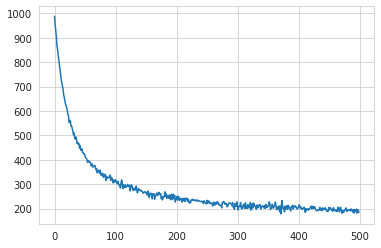

In [287]:
plt.plot(vi_res1)

In [0]:
post_samples1a = mf1.surrogate_posterior.sample(1000)
post_samples1a[1] = tfb.Softplus().forward(post_samples1a[1])

In [12]:
t0 = time.time()
post_samples1a = mf1.do_sampling(num_samples, num_burnin)
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 162.07s.


In [13]:
mf1.set_x(5. + x)
t0 = time.time()
post_samples1b = mf1.do_sampling(num_samples, num_burnin)
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 162.95s.


In [219]:
post_pred_samples1a = sample_post_pred(10, model1, post_samples1a.all_states)
post_pred_samples1b = sample_post_pred(10, model1, post_samples1b.all_states)

array([4.14617384, 4.70453364, 5.16694731, 5.43960826, 6.50362144,
       4.42066516, 5.31666502, 5.68695041, 6.44501448, 6.12944937])

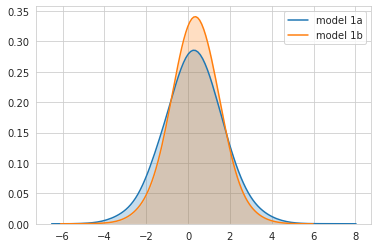

In [212]:
sns.set_style('whitegrid')
sns.kdeplot(post_pred_samples1a, shade = True, bw=0.5, label = "model 1a")
sns.kdeplot(post_pred_samples1b, shade = True, bw=0.5, label = "model 1b")


# Posterior Predictive

In [0]:
def sample_post_pred(n_per_mcmc_sample, model, post_samples):
  post_samples_mu = post_samples[0].numpy()
  post_samples_sigma = post_samples[1].numpy()

  return np.repeat(post_samples_mu, n_per_mcmc_sample) + \
    np.repeat(post_samples_sigma, n_per_mcmc_sample) * \
    np.random.standard_normal((n_per_mcmc_sample * len(post_samples_mu),))

# Single Simulation

### Fit models

Most of run time is one-time model compilation.

In [0]:
num_burnin = 500
num_samples = 1000
n = 10
x = sim_data(n)

In [0]:
model1 = build_model(n=n, prior_params = model1_prior_params)
mf1 = ModelFitter(model1, x)

model2 = build_model(n=n, prior_params = model2_prior_params)
mf2 = ModelFitter(model2, x)

In [180]:
t0 = time.time()
post_samples1 = mf1.do_sampling(num_samples, num_burnin)
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Tensor("JointDistributionNamed/log_prob/add_2:0", shape=(), dtype=float32)
Inference ran in 6.41s.


In [181]:
t0 = time.time()
post_samples2 = mf2.do_sampling(num_samples, num_burnin)
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Tensor("JointDistributionNamed/log_prob/add_2:0", shape=(), dtype=float32)
Inference ran in 6.05s.


In [182]:
post_samples2.all_states

[<tf.Tensor: shape=(1000,), dtype=float32, numpy=
 array([ 7.92448163e-01,  7.92448163e-01,  2.30484664e-01,  7.51840413e-01,
         7.51840413e-01,  2.51931220e-01,  2.51931220e-01, -1.60678253e-02,
         8.02746654e-01,  1.50946558e+00,  8.99173915e-01,  4.61155474e-01,
         4.61155474e-01,  7.95812726e-01,  6.05523825e-01,  6.05523825e-01,
         8.55257630e-01,  9.96202826e-01,  1.04268301e+00,  1.11988175e+00,
         4.48697031e-01,  1.09311032e+00,  4.12600815e-01,  1.06011426e+00,
         7.98200592e-02, -4.06622374e-03,  1.72138512e+00,  3.16253483e-01,
         5.25972605e-01, -1.88313022e-01,  7.49978840e-01,  2.37397289e+00,
         2.37397289e+00,  2.37397289e+00,  2.37397289e+00,  1.98764098e+00,
        -3.41294974e-01,  4.47816640e-01, -1.31034046e-01,  1.23308575e+00,
         1.23308575e+00,  4.87487674e-01,  5.65789044e-01,  8.77541006e-01,
         2.59565681e-01,  9.77745771e-01,  7.95556128e-01,  9.30029094e-01,
         8.63375723e-01,  1.38766086e+

### Obtain and plot samples from posterior predictive

In [0]:
post_pred_samples1 = sample_post_pred(10, model1, post_samples1.all_states)
post_pred_samples2 = sample_post_pred(10, model2, post_samples2.all_states)

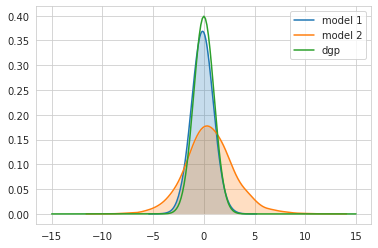

In [195]:
sns.set_style('whitegrid')
sns.kdeplot(post_pred_samples1, shade = True, bw=0.5, label = "model 1")
sns.kdeplot(post_pred_samples2, shade = True, bw=0.5, label = "model 2")
x = np.linspace(-15., 15., 201)
sns.lineplot(x = x, y = stats.norm.pdf(x), label = "dgp")

### Scores from posterior predictive samples

In [196]:
obs = np.random.standard_normal((1,))

pd.DataFrame({
  'model': ('model1', 'model2'),
  'log_score': (
    log_score_from_sample(post_pred_samples1, obs, binwidth = 0.1),
    log_score_from_sample(post_pred_samples2, obs, binwidth = 0.1)
  ),
  'interval_score_90': (
    interval_score_from_sample(post_pred_samples1, obs, interval_size = 0.9),
    interval_score_from_sample(post_pred_samples2, obs, interval_size = 0.9)
  ),
  'interval_score_50': (
    interval_score_from_sample(post_pred_samples1, obs, interval_size = 0.5),
    interval_score_from_sample(post_pred_samples2, obs, interval_size = 0.5)
  ),
  'interval_ae_score_90': (
    interval_ae_score_from_sample(post_pred_samples1, obs, interval_size = 0.9),
    interval_ae_score_from_sample(post_pred_samples2, obs, interval_size = 0.9)
  ),
  'interval_ae_score_50': (
    interval_ae_score_from_sample(post_pred_samples1, obs, interval_size = 0.5),
    interval_ae_score_from_sample(post_pred_samples2, obs, interval_size = 0.5)
  )
})

,model,log_score,interval_score_90,interval_score_50,interval_ae_score_90,interval_ae_score_50
0,model1,[-1.0023934309275633],[3.205153155398766],[1.2802547493823395],[3.40515557888932],[1.480257172872894]
1,model2,[-1.8312806180152585],[7.91861747326767],[2.9598616762338343],[8.735431808650672],[3.776676011616836]


# Repeated Simulation